This file loads csv data collected from our IMU, plots the accelerometer and gyroscope data, find peaks, and calculate stroke rate.

In [47]:
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:

# Load the data
#file_path = "../downloaded_files/datatest.csv"

file_path = "data/10sec7stroke.csv"

data = pd.read_csv(file_path, on_bad_lines='skip') 

# Ignore this
data_set_temp_string = 'data6'

In [67]:


# Display the first few rows of the dataset to ensure it loaded correctly
print("Data preview:")
print(data.head())

# Flag to show or hide plots
show_plots = True

# Extract the columns
timestamps = data['Time']
accel_x = data['Accel_X']
accel_y = data['Accel_Y']
accel_z = data['Accel_Z']
gyro_x = data['Gyro_X']
gyro_y = data['Gyro_Y']
gyro_z = data['Gyro_Z']

Data preview:
           Time  Accel_X  Accel_Y  Accel_Z  Gyro_X  Gyro_Y  Gyro_Z
0  1.740864e+09 -10904.0    -52.0  13776.0  -225.0   227.0    92.0
1  1.740864e+09 -10848.0    -48.0  13732.0  -250.0   239.0   105.0
2  1.740864e+09 -10816.0    -56.0  13636.0  -239.0   255.0   101.0
3  1.740864e+09 -10812.0   -128.0  13712.0  -235.0   223.0    81.0
4  1.740864e+09 -10936.0   -112.0  13636.0  -259.0   238.0   103.0


In [68]:
from scipy.signal import savgol_filter

print(len(accel_x))
# Apply Savitzky-Golay filter twice for extra smoothing
smoothed_accel_x = savgol_filter(savgol_filter(accel_x, window_length=4, polyorder=2), window_length=4, polyorder=2)
smoothed_accel_y = savgol_filter(savgol_filter(accel_y, window_length=25, polyorder=2), window_length=22, polyorder=2)
smoothed_accel_z = savgol_filter(savgol_filter(accel_z, window_length=25, polyorder=2), window_length=25, polyorder=2)
smoothed_gyro_x = savgol_filter(savgol_filter(gyro_x, window_length=25, polyorder=2), window_length=25, polyorder=2)
smoothed_gyro_y = savgol_filter(savgol_filter(gyro_y, window_length=25, polyorder=2), window_length=25, polyorder=2)
smoothed_gyro_z = savgol_filter(savgol_filter(gyro_z, window_length=25, polyorder=2), window_length=25, polyorder=2)


1382


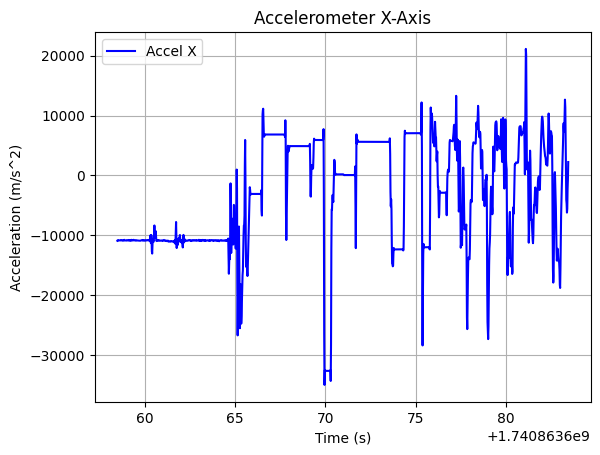

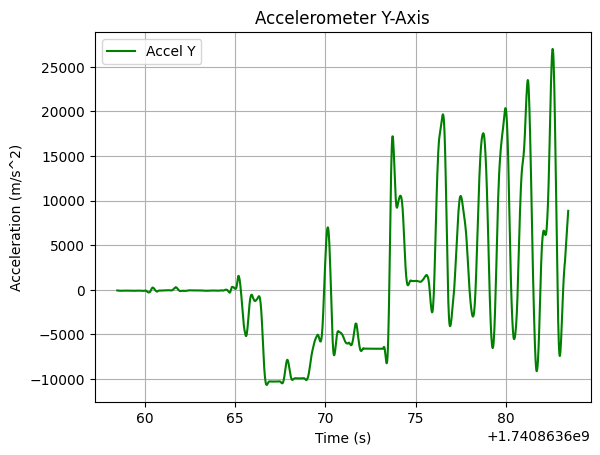

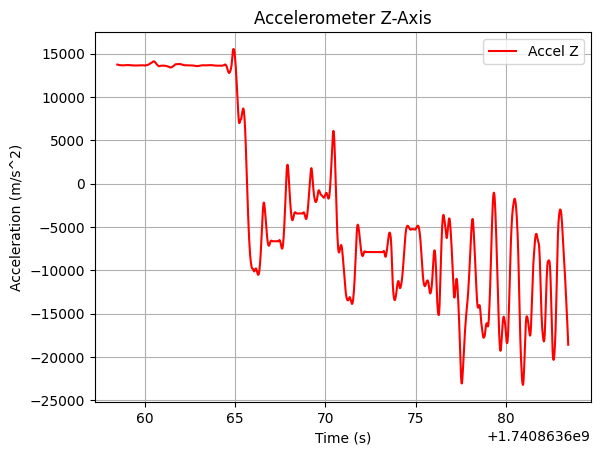

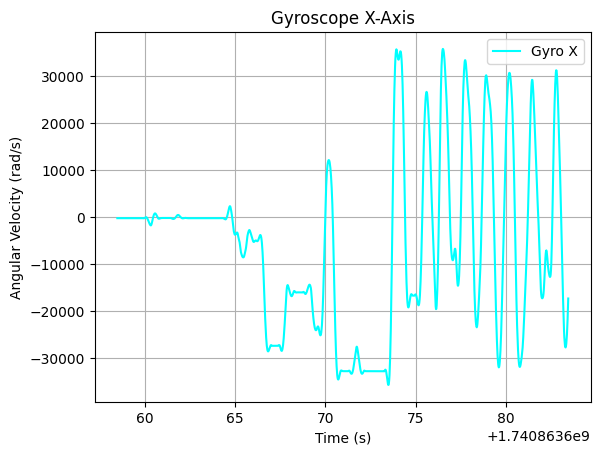

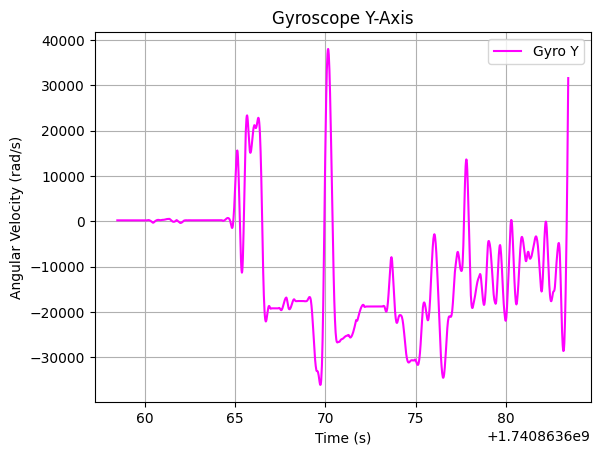

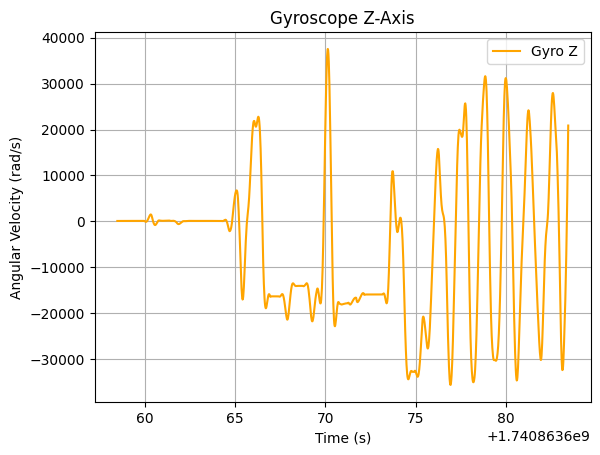

In [69]:
# Adjust timestamps to match the length of smoothed data and convert to seconds
adjusted_timestamps = timestamps[:len(smoothed_accel_x)]  


# Now, use adjusted_timestamps in the plots
plt.figure()
plt.plot(adjusted_timestamps, smoothed_accel_x, label="Accel X", color='blue')
plt.title("Accelerometer X-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(adjusted_timestamps, smoothed_accel_y, label="Accel Y", color='green')
plt.title("Accelerometer Y-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(adjusted_timestamps, smoothed_accel_z, label="Accel Z", color='red')
plt.title("Accelerometer Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(adjusted_timestamps, smoothed_gyro_x, label="Gyro X", color='cyan')
plt.title("Gyroscope X-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (rad/s)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(adjusted_timestamps, smoothed_gyro_y, label="Gyro Y", color='magenta')
plt.title("Gyroscope Y-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (rad/s)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(adjusted_timestamps, smoothed_gyro_z, label="Gyro Z", color='orange')
plt.title("Gyroscope Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (rad/s)")
plt.grid(True)
plt.legend()
plt.show()


In [70]:
# SAVING BLOCK (Can ignore)

import os
import matplotlib.pyplot as plt

# Get the current working directory (assuming you're running from within 'esp IMU')
current_dir = os.getcwd()  # This should be inside 'esp IMU'
parent_dir = os.path.dirname(current_dir)  # Go up one level
save_path = os.path.join(parent_dir, "six_file_analysis", data_set_temp_string)


# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)

#  Define plot labels and data
plot_data = [
    ("Accelerometer X-Axis", "Acceleration (m/s^2)", "Accel_X.png", smoothed_accel_x, "blue"),
    ("Accelerometer Y-Axis", "Acceleration (m/s^2)", "Accel_Y.png", smoothed_accel_y, "green"),
    ("Accelerometer Z-Axis", "Acceleration (m/s^2)", "Accel_Z.png", smoothed_accel_z, "red"),
    ("Gyroscope X-Axis", "Angular Velocity (rad/s)", "Gyro_X.png", smoothed_gyro_x, "cyan"),
    ("Gyroscope Y-Axis", "Angular Velocity (rad/s)", "Gyro_Y.png", smoothed_gyro_y, "magenta"),
    ("Gyroscope Z-Axis", "Angular Velocity (rad/s)", "Gyro_Z.png", smoothed_gyro_z, "orange"),
]

# Generate and save plots
for title, ylabel, filename, data, color in plot_data:
    plt.figure()
    plt.plot(adjusted_timestamps, data, label=title.split()[1], color=color)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(save_path, filename))  # Save the plot
    plt.close()  # Close the figure to free memory

print(f"Plots saved successfully in {save_path}")

Plots saved successfully in c:\Users\chenn\Documents\BMEG457\FORM24\six_file_analysis\data6


In [71]:
import os
import matplotlib.pyplot as plt

# Save the plot
save_path = os.path.join(os.path.dirname(os.getcwd()), "six_file_analysis", data_set_temp_string)
os.makedirs(save_path, exist_ok=True)

# Plot adjusted timestamps vs smoothed_gyro_z
plt.figure(figsize=(12, 6))
plt.plot(adjusted_timestamps, smoothed_gyro_z, label="Smoothed Gyro Z", color="orange")
plt.title("Smoothed Gyroscope Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (rad/s)")
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig(os.path.join(save_path, "Smoothed_Gyro_Z.png"))
plt.close()

print(f"Smoothed Gyro Z plot saved successfully in {save_path}")


Smoothed Gyro Z plot saved successfully in c:\Users\chenn\Documents\BMEG457\FORM24\six_file_analysis\data6


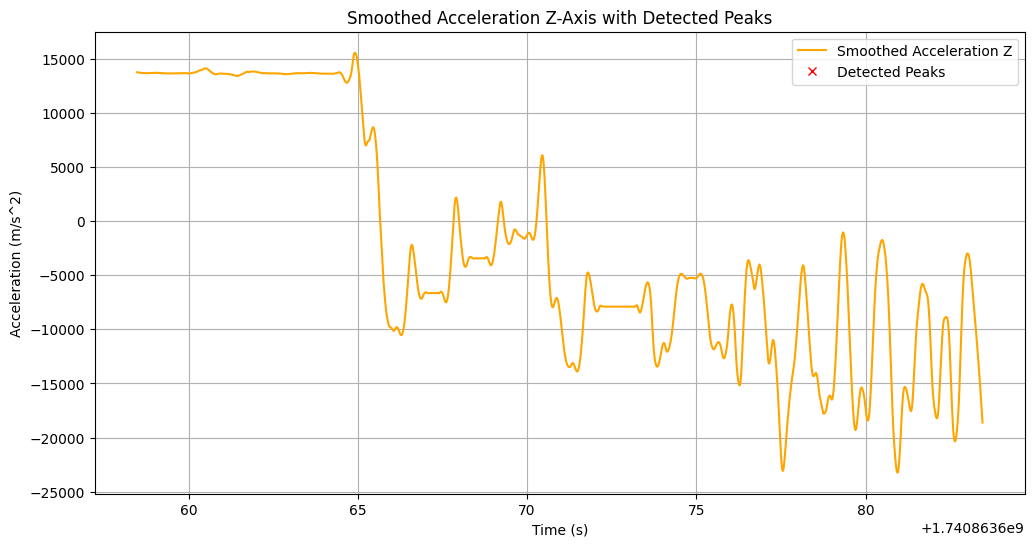

Mean: -2359.38, Std Dev: 10947.13, Max: 15548.62
Dynamic Height Threshold: 11013.11
Dynamic Distance Threshold: 60 samples
Total Detected Peaks: 0
Smoothed Gyro Z plot with peaks saved successfully in c:\Users\chenn\Documents\BMEG457\FORM24\six_file_analysis\data6


In [72]:
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import os

# Use adjusted timestamps and smoothed gyro data
timestamps = np.array(adjusted_timestamps) # Ensure timestamps are NumPy array
gyro_z = np.array(smoothed_accel_z)  # Use smoothed gyro Z data

# Calculate dynamic thresholds
mean_value = np.mean(smoothed_accel_z)
std_dev = np.std(smoothed_accel_z)
max_value = np.max(smoothed_accel_z)

# Dynamically set the 'height' threshold based on mean and standard deviation
height_threshold = 0.9 * mean_value + 1.2 * std_dev  

# Dynamically set the 'distance' between peaks (based on sampling rate or data characteristics)
sampling_rate = 30  # Assuming data is collected at 30Hz
distance_threshold = int(sampling_rate * 2)  # Peaks can't be within this distance threshold.

# Detect peaks
peaks, properties = find_peaks(
    smoothed_accel_z,
    height=height_threshold,  # Minimum height
    distance=distance_threshold,  # Minimum distance between peaks
    prominence=0.5 * std_dev 
)

# Plot smoothed gyro Z data with detected peaks
plt.figure(figsize=(12, 6))
plt.plot(timestamps, smoothed_accel_z, label='Smoothed Acceleration Z', color='orange')
plt.plot(timestamps[peaks], gyro_z[peaks], 'rx', label='Detected Peaks')
plt.title('Smoothed Acceleration Z-Axis with Detected Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

# Save the plot
save_path = os.path.join(os.path.dirname(os.getcwd()), "six_file_analysis", data_set_temp_string)
os.makedirs(save_path, exist_ok=True)
plt.savefig(os.path.join(save_path, "Smoothed_Accel_Z_Peaks.png"))
plt.close()

# Print debugging info
print(f"Mean: {mean_value:.2f}, Std Dev: {std_dev:.2f}, Max: {max_value:.2f}")
print(f"Dynamic Height Threshold: {height_threshold:.2f}")
print(f"Dynamic Distance Threshold: {distance_threshold} samples")
print(f"Total Detected Peaks: {len(peaks)}")
print(f"Smoothed Gyro Z plot with peaks saved successfully in {save_path}")


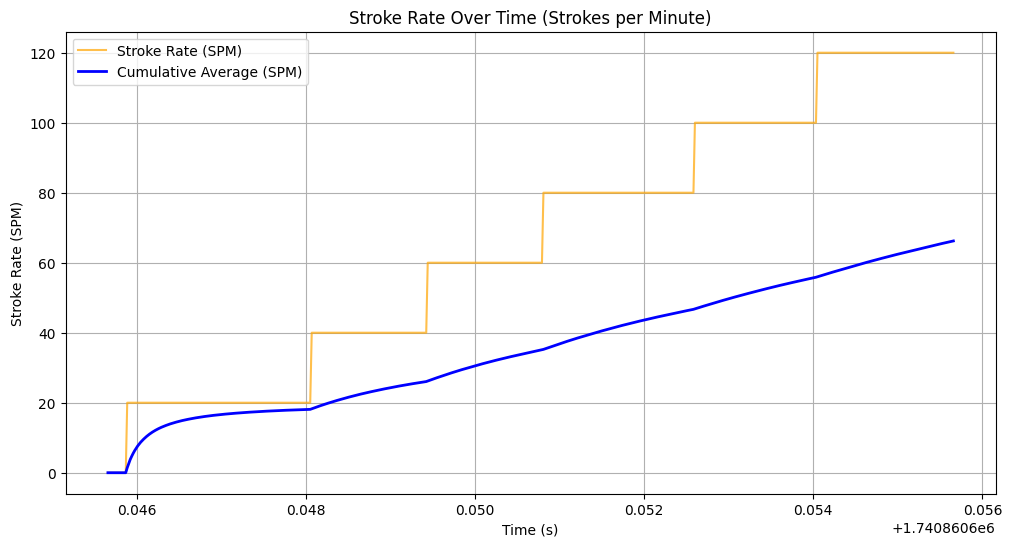

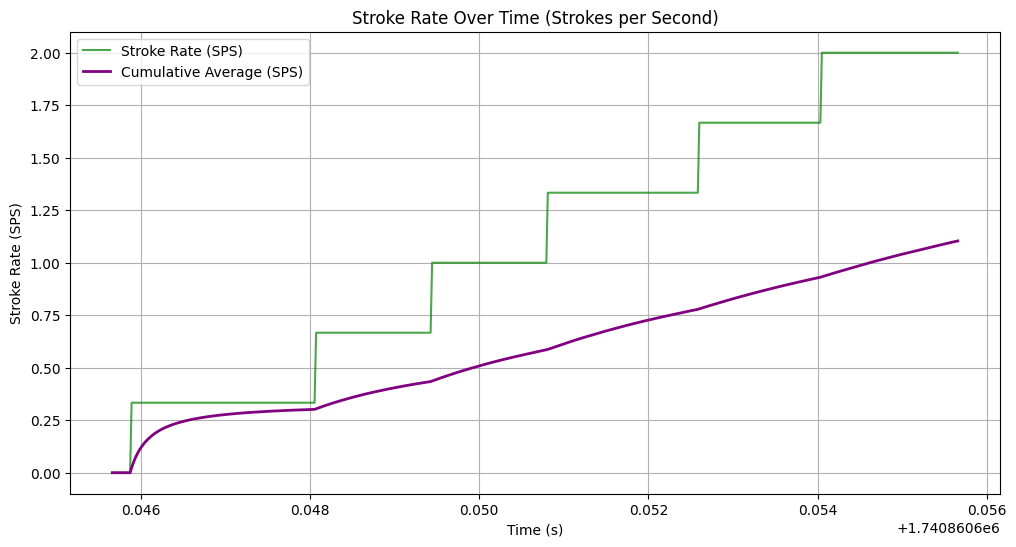

Final Cumulative Average Stroke Rate: 66.22 strokes/minute
Final Cumulative Average Stroke Rate: 1.10 strokes/second
Ground Truth Stroke Rate: 36015.95 strokes/minute
Ground Truth Stroke Rate: 600.27 strokes/second


In [55]:
# This Block calculates stroke rate.
# It uses a sliding time window of the last 3 seconds to count 
# how many strokes occurred in that time.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure timestamps are NumPy array for easier calculations
# 
#timestamps = np.array(adjusted_timestamps) 
timestamps = np.array(adjusted_timestamps) # This is temporary for the 6 data files, had to multiple by 1000 ^2 to convert our units back...

# Calculate stroke rate (SPM: Strokes Per Minute) and SPS (Strokes Per Second)
stroke_rate_spm = []
stroke_rate_sps = []  # Strokes per second
cumulative_spm = []  # Cumulative average SPM
cumulative_sps = []  # Cumulative average SPS
window = 3  # Window size in seconds for stroke rate calculation

for i, t in enumerate(timestamps):
    # Count peaks in the last `window` seconds
    start_time = t - window
    valid_peaks = [p for p in peaks if timestamps[p] >= start_time and timestamps[p] <= t]
    
    # Stroke rate in strokes per minute
    rate_spm = len(valid_peaks) * (60 / window)  # Convert to strokes per minute
    stroke_rate_spm.append(rate_spm)
    
    # Stroke rate in strokes per second
    rate_sps = len(valid_peaks) / window  # Convert to strokes per second
    stroke_rate_sps.append(rate_sps)
    
    # Cumulative averages
    cumulative_spm.append(sum(stroke_rate_spm) / len(stroke_rate_spm))  # Average of SPM so far
    cumulative_sps.append(sum(stroke_rate_sps) / len(stroke_rate_sps))  # Average of SPS so far

# Plot the stroke rate (Strokes per Minute) with cumulative average
plt.figure(figsize=(12, 6))
plt.plot(timestamps, stroke_rate_spm, label='Stroke Rate (SPM)', color='orange', alpha=0.7)
plt.plot(timestamps, cumulative_spm, label='Cumulative Average (SPM)', color='blue', linewidth=2)
plt.title('Stroke Rate Over Time (Strokes per Minute)')
plt.xlabel('Time (s)')
plt.ylabel('Stroke Rate (SPM)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the stroke rate (Strokes per Second) with cumulative average
plt.figure(figsize=(12, 6))
plt.plot(timestamps, stroke_rate_sps, label='Stroke Rate (SPS)', color='green', alpha=0.7)
plt.plot(timestamps, cumulative_sps, label='Cumulative Average (SPS)', color='purple', linewidth=2)
plt.title('Stroke Rate Over Time (Strokes per Second)')
plt.xlabel('Time (s)')
plt.ylabel('Stroke Rate (SPS)')
plt.legend()
plt.grid(True)
plt.show()

# Final cumulative averages
final_spm_average = cumulative_spm[-1]  # Final cumulative average SPM
final_sps_average = cumulative_sps[-1]  # Final cumulative average SPS

# Ground truth values
total_strokes = len(peaks)  # Total number of peaks (strokes)
total_time_seconds = timestamps[-1] - timestamps[0]  # Total duration in seconds
total_time_minutes = total_time_seconds / 60.0  # Total duration in minutes
ground_truth_spm = total_strokes / total_time_minutes  # Ground truth strokes per minute
ground_truth_sps = total_strokes / total_time_seconds  # Ground truth strokes per second

# Print final cumulative averages and ground truth
print(f"Final Cumulative Average Stroke Rate: {final_spm_average:.2f} strokes/minute")
print(f"Final Cumulative Average Stroke Rate: {final_sps_average:.2f} strokes/second")
print(f"Ground Truth Stroke Rate: {ground_truth_spm:.2f} strokes/minute")
print(f"Ground Truth Stroke Rate: {ground_truth_sps:.2f} strokes/second")


In [56]:
import os
import matplotlib.pyplot as plt

# Create save path
save_path = os.path.join(os.path.dirname(os.getcwd()), "six_file_analysis", data_set_temp_string)
os.makedirs(save_path, exist_ok=True)

# Save Stroke Rate (SPM) plot
plt.figure(figsize=(12, 6))
plt.plot(timestamps, stroke_rate_spm, label='Stroke Rate (SPM)', color='orange', alpha=0.7)
plt.plot(timestamps, cumulative_spm, label='Cumulative Average (SPM)', color='blue', linewidth=2)
plt.title('Stroke Rate Over Time (Strokes per Minute)')
plt.xlabel('Time (s)')
plt.ylabel('Stroke Rate (SPM)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_path, "Stroke_Rate_SPM.png"))  # Save the plot
plt.close()

# Save Stroke Rate (SPS) plot
plt.figure(figsize=(12, 6))
plt.plot(timestamps, stroke_rate_sps, label='Stroke Rate (SPS)', color='green', alpha=0.7)
plt.plot(timestamps, cumulative_sps, label='Cumulative Average (SPS)', color='purple', linewidth=2)
plt.title('Stroke Rate Over Time (Strokes per Second)')
plt.xlabel('Time (s)')
plt.ylabel('Stroke Rate (SPS)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_path, "Stroke_Rate_SPS.png"))  # Save the plot
plt.close()

print(f"Plots saved successfully in {save_path}")


Plots saved successfully in c:\Users\chenn\Documents\BMEG457\FORM24\six_file_analysis\data6
